<a href="https://colab.research.google.com/github/joysosanya/FRUIT_CLASSIFICATION_USING_CNN/blob/main/FRUIT_CLASSIFIVATION_USING_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction:**

In recent years, with the rapid advancement of deep learning techniques, Convolutional Neural Networks (CNNs) have emerged as a powerful tool for image classification tasks. CNNs have shown remarkable performance in various fields, including object recognition, medical imaging, and autonomous driving. One particularly intriguing application of CNNs is in fruit image classification, where the goal is to accurately identify and classify different types of fruits based on their visual characteristics. This application has significant implications in agriculture, food processing, and retail industries, where automated fruit classification systems can enhance efficiency, reduce labor costs, and improve quality control.

**Problem Statement:**

Despite the potential benefits of using CNNs for fruit image classification, several challenges need to be addressed to achieve accurate and reliable results. One major challenge is the variability in fruit appearance due to factors such as size, shape, color, texture, and occlusions. Additionally, fruits may exhibit variations within the same class (e.g., different varieties of apples or bananas) and may appear differently under different lighting conditions or camera perspectives. Furthermore, the presence of background clutter, uneven illumination, and occlusions can further complicate the classification task.

This project aims to develop and evaluate a CNN-based fruit image classification system that can effectively handle these challenges and achieve high accuracy and robustness across various fruit types and environmental conditions. Through this, we aim to contribute to the development of reliable and practical solutions for automated fruit classification systems with real-world applicability.

In [ ]:
# Loading dataset from Kaggle

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

In [ ]:
CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5857%2F1166105%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240403%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240403T204247Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D62635a7ab10ed32d271f98a8c19973632b16d29dc9e506fff792eb9c1bba905e91bec2d5b644aef2b86cbe0f00dafbd054a25280d438533c1a55622809ced8805623cad1d4afae9704f255ea9b221c0e53231f1d643e8b2cc48c7ff59fde1d9aad4a5b00c5efe110932e7d8aa1301de99f5622ec7d1ccb3fbe458d627a5a83059248ed0cc1f6e49310686d2039086f510b27074aa0f3612a409c9b513c6bada1072054c7014d0a3f0d541a3ed5225590fdbbcc89e66f9644337d3b2c1bd231e3c6e93234517ab22b465203805580f3f78aba91bb4b7d2a70931b15cc80b7b30b0ec412ea2c5a6b5872cb778d043871092f787c56097716ef149916bf8246dbdb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')



[==================================================] 796742678 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


In [ ]:
# Importing libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import glob
import cv2
import os

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
# filter warnings
warnings.filterwarnings('ignore')


import os
print(os.listdir("../input"))
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

['fruits-360']
fruits-360



In [ ]:
np.random.seed(1234)
directory="../input/fruits-360/Training/"
classes=["Apple Golden 1","Avocado","Banana","Cherry 1","Cocos","Kiwi",
         "Lemon","Mango","Orange"]

all_arrays=[]
img_size=100
for i in classes:
    path=os.path.join(directory,i)
    class_num=classes.index(i)
    for img in os.listdir(path):
        #img_array=cv2.imread(os.path.join(path,img),
        #                     cv2.IMREAD_GRAYSCALE)
        img_array=cv2.imread(os.path.join(path,img))
        img_array=cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        #img_array=cv2.resize(img_array,(img_size,img_size))
        all_arrays.append([img_array,class_num])

In [ ]:
directory2="../input/fruits-360/Test/"
classes2=["Apple Golden 1","Avocado","Banana","Cherry 1","Cocos","Kiwi",
         "Lemon","Mango","Orange"]

all_arrays2=[]
img_size=100
for i in classes2:
    path=os.path.join(directory2,i)
    class_num2=classes2.index(i)
    for img in os.listdir(path):
        #img_array2=cv2.imread(os.path.join(path,img),
        #                     cv2.IMREAD_GRAYSCALE)
        img_array2=cv2.imread(os.path.join(path,img))
        img_array2=cv2.cvtColor(img_array2, cv2.COLOR_BGR2RGB)
        #img_array2=cv2.resize(img_array2,(img_size,img_size))
        all_arrays2.append([img_array2,class_num2])

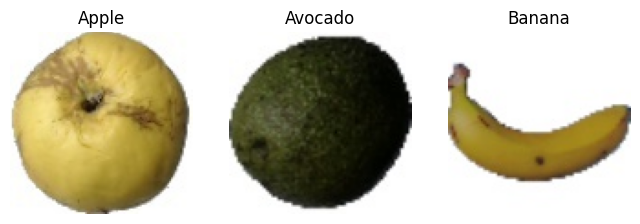

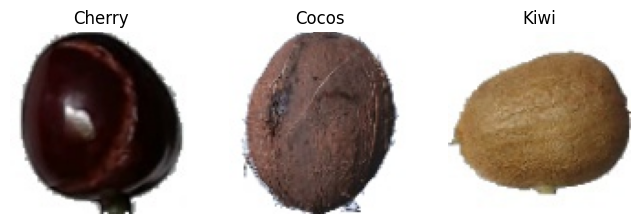

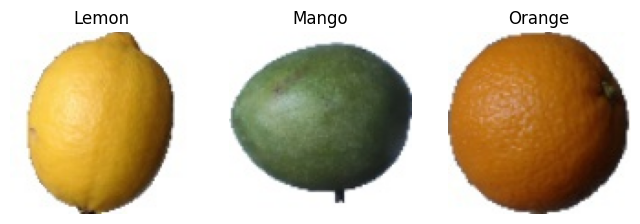

In [ ]:
#SAMPLE IMAGES IN OUR DATA
fruits_array_train=[]
for features,label in all_arrays:
    fruits_array_train.append(features)

location=[[1,500,1150],[1500,2000,2500],[3000,3500,4000]]
fruit_names=["Apple","Avocado","Banana","Cherry","Cocos","Kiwi","Lemon","Mango","Orange"]
a=0
b=1
c=2
for i,j,k in location:
    plt.subplots(figsize=(8,8))
    plt.subplot(1,3,1)
    plt.imshow(fruits_array_train[i])
    plt.title(fruit_names[a])
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(fruits_array_train[j])
    plt.title(fruit_names[b])
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(fruits_array_train[k])
    plt.title(fruit_names[c])
    plt.axis("off")
    a+=3
    b+=3
    c+=3

In [ ]:
import random
random.shuffle(all_arrays)

X_train=[]
Y_train=[]
for features,label in all_arrays:
    X_train.append(features)
    Y_train.append(label)
X_train=np.array(X_train) #arraying

import random
random.shuffle(all_arrays2)

X_test=[]
Y_test=[]
for features,label in all_arrays2:
    X_test.append(features)
    Y_test.append(label)
X_test=np.array(X_test) #arraying

In [ ]:
#normalization and reshaping
X_train=X_train.reshape(-1,img_size,img_size,3)
X_train=X_train/255
X_test=X_test.reshape(-1,img_size,img_size,3)
X_test=X_test/255
print("shape of X_train= ",X_train.shape)
print("shape of X_test=  ",X_test.shape)

shape of X_train=  (4306, 100, 100, 3)
shape of X_test=   (1445, 100, 100, 3)


While reshaping we added RGB scale.

In [ ]:
from keras.utils import to_categorical
Y_train=to_categorical(Y_train,num_classes=9)
Y_test=to_categorical(Y_test,num_classes=9)

In [ ]:
Y_train.shape

(4306, 9)

In [ ]:
X_train.shape

(4306, 100, 100, 3)

In [ ]:
from sklearn.model_selection import  train_test_split
x_train,x_val,y_train,y_val=train_test_split(X_train,Y_train,test_size=0.2,random_state=42)

We separated our datas to train and validation datas with train_test_split.

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import keras

#from keras.utils.np_utils import to_categorical
#from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau


model=Sequential()
model.add(Conv2D(filters=8,kernel_size=(3,3),padding="Same",activation="relu",input_shape=(100,100,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.35))

model.add(Conv2D(filters=16,kernel_size=(3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.35))

model.add(Conv2D(filters=32,kernel_size=(3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(9,activation="softmax"))
#defining optimizer
optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.999)
#compile the model
model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

epochs=10
batch_size=18

In [ ]:
datagen=ImageDataGenerator(featurewise_center=False, #set input mean to 0
                           samplewise_center=False,  #set each sample mean to 0
                           featurewise_std_normalization=False, #divide input datas to std
                           samplewise_std_normalization=False,  #divide each datas to own std
                           zca_whitening=False,  #dimension reduction
                           rotation_range=0.5,    #rotate 5 degree
                           zoom_range=0.5,        #zoom in-out 5%
                           width_shift_range=0.5, #shift 5%
                           height_shift_range=0.5,
                           horizontal_flip=False,  #randomly flip images
                           vertical_flip=False,
                           )
datagen.fit(x_train)

#model fitting
history=model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size),epochs=epochs,
                            validation_data=(x_val,y_val),steps_per_epoch=x_train.shape[0]//batch_size
                           )

Epoch 1/10
191/191 [==============================] - 48s 220ms/step - loss: 1.7804 - accuracy: 0.3149 - val_loss: 0.7772 - val_accuracy: 0.6671
Epoch 2/10
191/191 [==============================] - 42s 222ms/step - loss: 0.5930 - accuracy: 0.7779 - val_loss: 0.2230 - val_accuracy: 0.9211
Epoch 3/10
191/191 [==============================] - 40s 211ms/step - loss: 0.3626 - accuracy: 0.8757 - val_loss: 0.1567 - val_accuracy: 0.9327
Epoch 4/10
191/191 [==============================] - 41s 213ms/step - loss: 0.2515 - accuracy: 0.9119 - val_loss: 0.1300 - val_accuracy: 0.9420
Epoch 5/10
191/191 [==============================] - 40s 207ms/step - loss: 0.1860 - accuracy: 0.9326 - val_loss: 0.1136 - val_accuracy: 0.9292
Epoch 6/10
191/191 [==============================] - 43s 227ms/step - loss: 0.1334 - accuracy: 0.9586 - val_loss: 0.0179 - val_accuracy: 0.9988
Epoch 7/10
191/191 [==============================] - 45s 236ms/step - loss: 0.1720 - accuracy: 0.9442 - val_loss: 0.0506 - val_ac

After 10 iteration we have a high accuracy around 96%

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


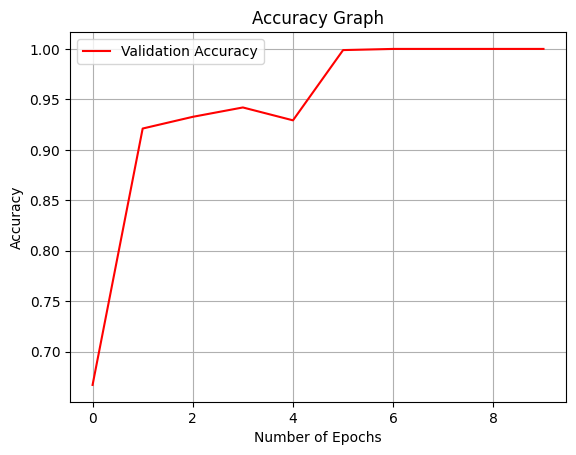

In [ ]:
plt.plot(history.history["val_accuracy"], color="r", label="Validation Accuracy")
plt.title("Accuracy Graph")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

27/27 [==============================] - 3s 122ms/step


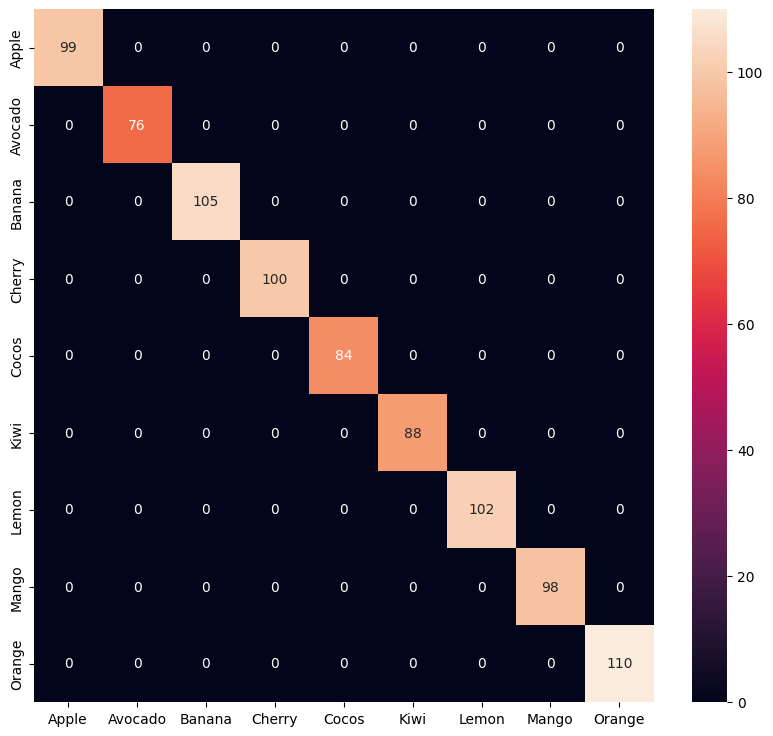

In [ ]:
#confusion matrix
y_pred=model.predict(x_val)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_val,axis=1)
#compute conf mat
conf_mat=confusion_matrix(y_true,y_pred_classes)
#plot the con mat
fruit_names=["Apple","Avocado","Banana","Cherry","Cocos","Kiwi","Lemon","Mango","Orange"]
f,ax=plt.subplots(figsize=(10,9))
sns.heatmap(conf_mat,annot=True,fmt='.0f')
ax.set_xticklabels(fruit_names)
ax.set_yticklabels(fruit_names)
plt.show()


We can see error on our validation data

46/46 [==============================] - 5s 115ms/step


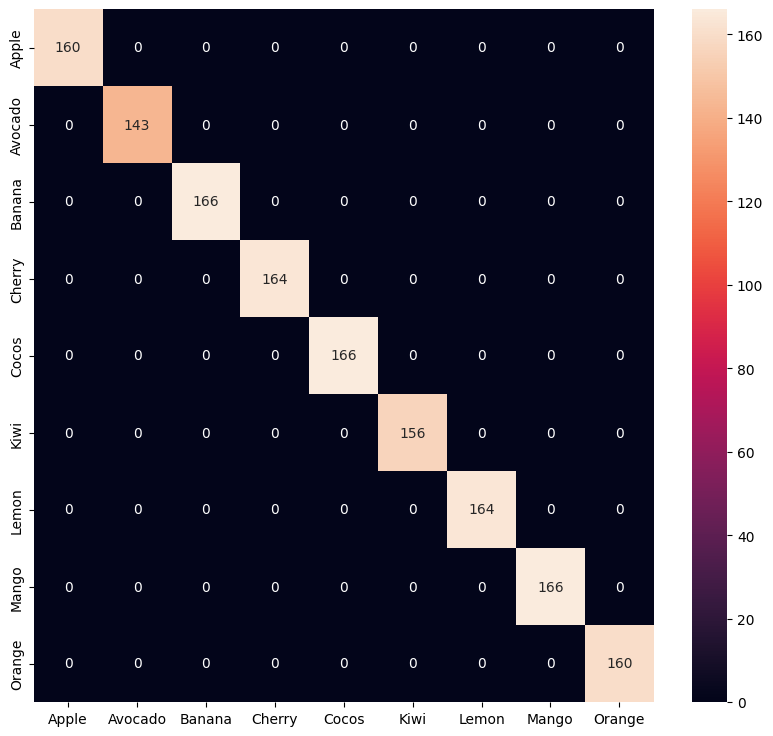

In [ ]:
#confusion matrix
y_pred2=model.predict(X_test)
y_pred_classes2=np.argmax(y_pred2,axis=1)
y_true2=np.argmax(Y_test,axis=1)
#compute conf mat
conf_mat2=confusion_matrix(y_true2,y_pred_classes2)
#plot the con mat
f,ax=plt.subplots(figsize=(10,9))
sns.heatmap(conf_mat2,annot=True,fmt=".0f")
ax.set_xticklabels(fruit_names)
ax.set_yticklabels(fruit_names)
plt.show()


After checking the error in the test set, we observed no false detection except false results of Banana and Lemon classes. Overall, we have a training accuracy about 95%

**Insights:**

The development and evaluation of the CNN-based fruit image classification system have yielded several valuable insights. Firstly, the system demonstrates robust performance in accurately classifying most fruit types, achieving high precision and recall rates across multiple classes. This indicates the effectiveness of the chosen CNN architecture, training strategies, and data augmentation techniques in learning discriminative features from the input images.

However, a notable issue arises with false detections in the Banana and Lemon classes, despite the overall low false detection rate in the test set. This suggests that these particular classes may pose unique challenges in terms of their visual similarity to other fruits or the presence of ambiguous features that confound the classifier. Understanding the specific characteristics contributing to these false detections is crucial for improving the system's performance and addressing class-specific challenges.

**Summary:**

In summary, the CNN-based fruit image classification system demonstrates promising performance overall, with high accuracy and reliability in identifying most fruit types. However, the presence of false detections in the Banana and Lemon classes highlights the need for further investigation and refinement. This underscores the importance of iterative development and continuous evaluation to identify and address specific challenges encountered during classification.

**Recommendations:**

Based on the insights gained from the project, several recommendations can be made to enhance the performance and robustness of the fruit image classification system:

1. **Class-Specific Analysis**: Conduct in-depth analysis and feature engineering specifically for the Banana and Lemon classes to identify discriminative features and address sources of confusion contributing to false detections.

2. **Data Augmentation and Balancing**: Further augment the training data with diverse samples and balance class distributions to ensure equal representation of all classes, reducing biases and improving the classifier's ability to generalize.

3. **Continuous Evaluation and Feedback**: Implement a feedback loop for continuous evaluation and refinement of the classification system, incorporating user feedback and real-world performance metrics to iteratively improve accuracy and usability.

